# Group 11 
### Machine Learning on distributed dask cluster

#### Bharath Kumar Reddy Bhoothpur
#### Chandana Sai Sri Chirra
#### Nikhil Reddy Muppidi
#### Poojith Chandra Borra
#### Teja Vijayudu Rayankula



### Enabling the client for fargate distributed cluster testing

In [78]:
from dask.distributed import Client

client = Client('Dask-Scheduler.local-dask:8786')


/home/ec2-user/anaconda3/envs/daskpy36/lib/python3.6/site-packages/distributed/client.py:1079: VersionMismatchWarning: Mismatched versions found

cloudpickle
+-----------------------+---------+
|                       | version |
+-----------------------+---------+
| client                | 2.0.0   |
| scheduler             | 1.6.0   |
| tcp://11.0.3.109:9000 | 1.6.0   |
| tcp://11.0.3.112:9000 | 1.6.0   |
| tcp://11.0.3.141:9000 | 1.6.0   |
| tcp://11.0.3.151:9000 | 1.6.0   |
| tcp://11.0.3.153:9000 | 1.6.0   |
| tcp://11.0.3.162:9000 | 1.6.0   |
| tcp://11.0.3.168:9000 | 1.6.0   |
| tcp://11.0.3.16:9000  | 1.6.0   |
| tcp://11.0.3.176:9000 | 1.6.0   |
| tcp://11.0.3.18:9000  | 1.6.0   |
| tcp://11.0.3.210:9000 | 1.6.0   |
| tcp://11.0.3.212:9000 | 1.6.0   |
| tcp://11.0.3.231:9000 | 1.6.0   |
| tcp://11.0.3.237:9000 | 1.6.0   |
| tcp://11.0.3.50:9000  | 1.6.0   |
| tcp://11.0.3.61:9000  | 1.6.0   |
| tcp://11.0.3.68:9000  | 1.6.0   |
| tcp://11.0.3.76:9000  | 1.6.0   |
| tcp://11.0.3

## Scale out the number of dask workers as needed for your data science work

### Enabling this when cluster is running on Fargate to scale out our cluster. 

In [2]:
!sudo aws ecs update-service --service Dask-Workers --desired-count 20 --cluster Fargate-Dask-Cluster

{
    "service": {
        "serviceArn": "arn:aws:ecs:us-east-1:201692355327:service/Fargate-Dask-Cluster/Dask-Workers",
        "serviceName": "Dask-Workers",
        "clusterArn": "arn:aws:ecs:us-east-1:201692355327:cluster/Fargate-Dask-Cluster",
        "loadBalancers": [],
        "serviceRegistries": [
            {
                "registryArn": "arn:aws:servicediscovery:us-east-1:201692355327:service/srv-tdi6ld3cs7pipo3e"
            }
        ],
        "status": "ACTIVE",
        "desiredCount": 20,
        "runningCount": 20,
        "pendingCount": 0,
        "launchType": "FARGATE",
        "platformVersion": "LATEST",
        "platformFamily": "Linux",
        "taskDefinition": "arn:aws:ecs:us-east-1:201692355327:task-definition/cloudformation-dask-workers-v1:2",
        "deploymentConfiguration": {
            "deploymentCircuitBreaker": {
                "enable": false,
                "rollback": false
            },
            "maximumPercent": 200,
            "mini

## Restart the client after scale out operation

We have to wait for ECS to scale out the cluster before running this step. 

In [79]:
client.restart()

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 20 Cores: 40 Memory: 81.92 GB


# Exploratory Data Analysis(EDA)

For data analysis, we will use Dask Dataframe and conduct various operations on the dataframe.

A Dask DataFrame is a huge parallel DataFrame that is split along the index into numerous smaller Pandas DataFrames. These Pandas DataFrames can be stored on disk for out-of-memory processing on a single system or across a cluster of devices. Many Pandas DataFrame activities are triggered by a single Dask DataFrame activity.

In [80]:
import s3fs
import dask.dataframe as dd

## We will import the dataset from the bucket provided by AWS

In [81]:
df = dd.read_csv(
    's3://nyc-tlc/trip data/yellow_tripdata_2018-*.csv', storage_options={'anon': True}, parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime']
)

##  Calculate the trip duration in seconds 
The duration of the trips can be calculated by taking the difference of dropoff time and pickup time. We are calculating this duration in seconds

In [82]:
df['trip_dur_secs'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds

In [83]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_dur_secs
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,198
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,1090
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,355
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80,1949
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,1068


## Calculate max trip duration across all trips

In [84]:
max_trip_duration = df.trip_dur_secs.max().compute()
print(max_trip_duration)

86399


## Calculate total mean for passengers across trips  by pickup date

In [85]:
df['pickup_date'] = df['tpep_dropoff_datetime'].dt.date

In [86]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_dur_secs,pickup_date
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,198,2018-01-01
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,1090,2018-01-01
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,355,2018-01-01
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80,1949,2018-01-01
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,1068,2018-01-01


In [87]:
df_mean_psngr_pickup_date = df.groupby('pickup_date').passenger_count.mean().compute()

In [88]:
df.shape[0].compute()

102804250

## Calculate total trips by pickup date

In [89]:
df_trips_by_pickup_date = df.groupby('pickup_date').store_and_fwd_flag.count().compute()

In [90]:
len(df_trips_by_pickup_date)

455

In [91]:
df_trips_by_pickup_date.head()

pickup_date
2002-12-31     10
2003-01-01     19
2008-12-31    278
2009-01-01    516
2017-01-02      1
Name: store_and_fwd_flag, dtype: int64

### We will now load and count number of rows

In [16]:
len(df)

102804250

In [17]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
trip_dur_secs                     int64
pickup_date                      object
dtype: object

## Persist  collections into memory
Client.compute and Client.persist calls submit task graphs to the cluster, which will return Future objects pointing to specific output tasks. Persist returns a replica of the collection with each block or partition replaced by a single future, while compute returns a single future per input. To summarize, use persist to maintain the entire collection on the cluster and compute when you only need a single future result.

In [92]:
from dask.distributed import Client, progress

In [93]:
df_persisted = client.persist(df)
print(df_persisted.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2018-01-01 00:21:05   2018-01-01 00:24:23                1   
1         1  2018-01-01 00:44:55   2018-01-01 01:03:05                1   
2         1  2018-01-01 00:08:26   2018-01-01 00:14:21                2   
3         1  2018-01-01 00:20:22   2018-01-01 00:52:51                1   
4         1  2018-01-01 00:09:18   2018-01-01 00:27:06                2   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.5           1                  N            41            24   
1            2.7           1                  N           239           140   
2            0.8           1                  N           262           141   
3           10.2           1                  N           140           257   
4            2.5           1                  N           246           239   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


## Compute the mean trip distance grouped by the number of passengers

In [94]:
grouped_df = df.groupby(df_persisted.passenger_count).trip_distance.mean().compute()
print(grouped_df)

passenger_count
0      2.794579
1      2.887231
2      3.086006
3      3.050260
4      3.106791
5      3.018695
6      2.989190
7      3.015897
8      5.193099
9      5.404800
192    0.950000
96     0.830000
Name: trip_distance, dtype: float64


## Compute Max trip distance

In [95]:
max_trip_dist = df_persisted.trip_distance.max().compute()
print(max_trip_dist)

189483.84


## We will now count the total trip distance and count for each vendor

In [96]:
df.groupby('VendorID').agg({'passenger_count':'count', 'trip_distance': 'sum'}).astype(int).reset_index()\
.rename(columns={'passenger_count':'Trip Count'}).compute()

,VendorID,Trip Count,trip_distance
0,1,42948686,120042180
1,2,59363813,180396669
2,4,491751,1329479


## Count Missing Values for Each Feature

In [23]:
df.isna().sum().compute()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
trip_dur_secs            0
pickup_date              0
dtype: int64

As we can see here, the data has no missing values and it's cleaned data.

## Visualize your Exploratory Data Analysis

Here we will demonstrate how to perform  Visual exploratory data analysis

## Selecting top 10 rides based on fare amount

In [97]:
most_paid_rides_dask = df[['PULocationID', 'fare_amount']].nlargest(10, "fare_amount")

## Visualizing most paid rides through Barplot

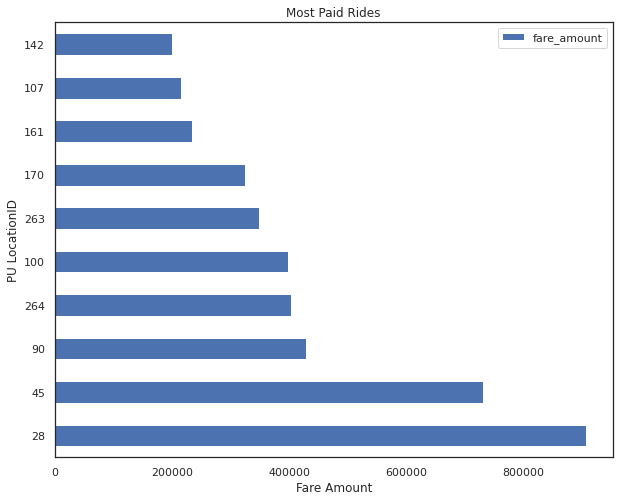

In [98]:
import matplotlib.pyplot as plt
most_paid_rides_dask.set_index('PULocationID',sorted=True).compute().plot(kind='barh',stacked=False, figsize=[10,8], legend=True)
plt.title('Most Paid Rides')
plt.xlabel('Fare Amount')
plt.ylabel('PU LocationID')
plt.show()


## Visualizing trip distance through Barplot

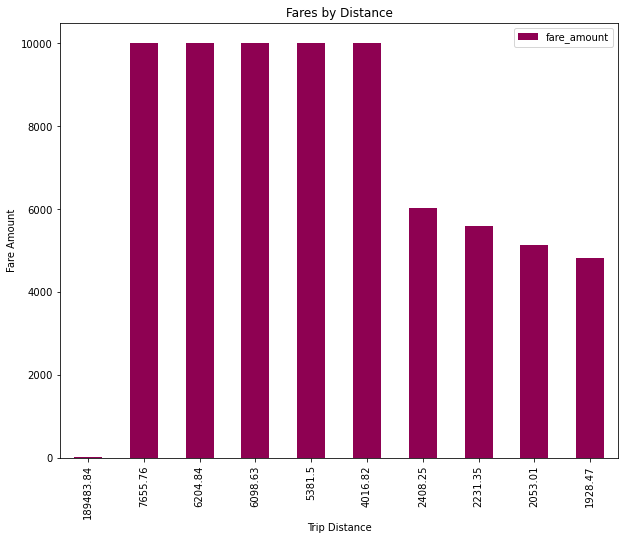

In [26]:
import matplotlib.pyplot as plt
most_paid_rides_dask2 = df[['trip_distance', 'fare_amount']].nlargest(10, "trip_distance")
most_paid_rides_dask2.set_index('trip_distance',sorted=True).compute().plot(kind='bar', colormap='PiYG', stacked=False, figsize=[10,8], legend=True)
plt.title('Fares by Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

## Vizualising the dataframe using a heatmap

In [38]:
corr = df.corr(method ='pearson')

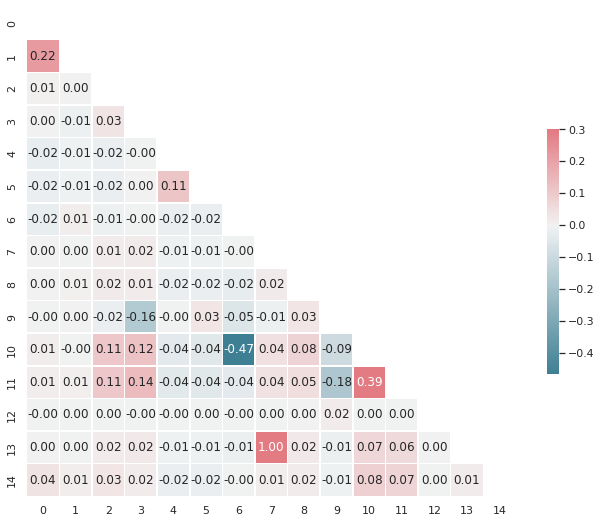

In [32]:
#!conda install --yes seaborn
import seaborn as sns
import numpy as np
def heatmap(corr):
    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt="3.2f",
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap(corr)

In [35]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, VendorID to pickup_date
dtypes: datetime64[ns](2), object(2), float64(8), int64(7)

# Regression modeling with  Scikit Learn and Distributed Dask

Now we will model the data and then perform regression on the dataset.

Many Scikit-Learn algorithms are written for parallel execution using Joblib, which natively provides thread-based and process-based parallelism. Joblib is what backs the n_jobs= parameter in normal use of Scikit-Learn. Dask can scale these Joblib-backed algorithms out to a cluster of machines by providing an alternative Joblib backend. 


### A modified version of the dataset will be used. For our models, we will use February 2018 as the sample data.

In [99]:
dfl = dd.read_csv(
    's3://nyc-tlc/trip data/yellow_tripdata_2018-02.csv', storage_options={'anon': True},
    parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
).sample(frac=0.8, replace=True)

### Preprocess data
1. Derive trip duration
2. Fill NaN value with zeros 
3. One-hot encode categorical variables

### 1. Deriving the trip duration

In [100]:
dfl['trip_duration'] = dfl['tpep_dropoff_datetime'] - dfl['tpep_pickup_datetime']

In [101]:
import numpy as np
dfl['trip_duration'] = dfl['trip_duration']/np.timedelta64(1,'D')
dfl['trip_duration'] = dfl['trip_duration'] * 24
dfl['trip_duration']

Dask Series Structure:
npartitions=12
    float64
        ...
     ...   
        ...
        ...
Name: trip_duration, dtype: float64
Dask Name: getitem, 180 tasks

In [102]:
len(dfl)

6793661

In [103]:
dfl.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
547472,1,2018-02-02 18:21:28,2018-02-02 18:28:58,1,0.80,1,N,234,90,1,6.5,1.0,0.5,1.65,0.0,0.3,9.95,0.125000
376786,2,2018-02-02 08:02:45,2018-02-02 08:09:26,5,0.35,1,N,100,186,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30,0.111389
493944,1,2018-02-02 15:15:07,2018-02-02 15:28:41,1,1.90,1,N,230,164,2,10.5,0.0,0.5,0.00,0.0,0.3,11.30,0.226111
388019,2,2018-02-02 08:04:06,2018-02-02 08:12:11,1,0.81,1,N,186,107,1,6.5,0.0,0.5,1.00,0.0,0.3,8.30,0.134722
519413,2,2018-02-02 16:23:14,2018-02-02 17:02:59,1,5.03,1,N,170,41,1,26.5,1.0,0.5,8.49,0.0,0.3,36.79,0.662500


### 2. Filling NaN value with zeros

In [104]:
dfl = dfl.fillna(value=0)

In [105]:
dfl = dd.get_dummies(dfl.categorize()).compute()

In [106]:
dfl.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,store_and_fwd_flag_N,store_and_fwd_flag_Y
547472,1,2018-02-02 18:21:28,2018-02-02 18:28:58,1,0.80,1,234,90,1,6.5,1.0,0.5,1.65,0.0,0.3,9.95,0.125000,1,0
376786,2,2018-02-02 08:02:45,2018-02-02 08:09:26,5,0.35,1,100,186,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30,0.111389,1,0
493944,1,2018-02-02 15:15:07,2018-02-02 15:28:41,1,1.90,1,230,164,2,10.5,0.0,0.5,0.00,0.0,0.3,11.30,0.226111,1,0
388019,2,2018-02-02 08:04:06,2018-02-02 08:12:11,1,0.81,1,186,107,1,6.5,0.0,0.5,1.00,0.0,0.3,8.30,0.134722,1,0
519413,2,2018-02-02 16:23:14,2018-02-02 17:02:59,1,5.03,1,170,41,1,26.5,1.0,0.5,8.49,0.0,0.3,36.79,0.662500,1,0


In [107]:
x = dfl[['VendorID','RatecodeID','PULocationID','DOLocationID','passenger_count','trip_distance','fare_amount','total_amount']]

In [108]:
y = dfl['trip_duration']

### Splitting the data for training and testing

In [109]:
from dask_ml.model_selection import train_test_split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [111]:
len(X_train), len(X_test), len(y_train), len(y_test)

(6114294, 679367, 6114294, 679367)

In [112]:
training_x = X_train.values
training_y = y_train.values

In [113]:
testing_x = X_test.values
testing_y = y_test.values

### We will be using Root Mean Squared error as the metric to measure and compare the performance of our models against each other.

In [114]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [115]:
def rmse(preds, actuals):
    error = mean_squared_error(actuals, preds)
    rmse = np.sqrt(error)
    print(rmse)

### Running Linear Regression model training on distributed dask cluster

In [66]:
import joblib
from dask_ml.linear_model import LinearRegression

with joblib.parallel_backend('dask'):
    lr = LinearRegression(random_state=1, fit_intercept=True)
    lr.fit(training_x,training_y)

### Run prediction on the trained model

In [67]:
preds = lr.predict(testing_x)
preds

array([0.23587751, 0.11303568, 0.25717115, ..., 0.26830248, 0.21250239,
       0.09502799])

In [69]:
rmse(preds,testing_y)

0.9954480590790822


### Running Logistic Regression Model on distributed dask cluster

In [71]:
from dask_ml.linear_model import LogisticRegression

with joblib.parallel_backend('dask'):
    lr = LogisticRegression(random_state=1, fit_intercept=True)
    lr.fit(training_x,training_y)

### Running prediction on the trained model

In [72]:
preds = lr.predict(testing_x)
preds

rmse(preds,testing_y)

1.0263909903089392


### Running the Poisson Regression model on the distributed dask clusted

In [74]:
from dask_ml.linear_model import PoissonRegression

with joblib.parallel_backend('dask'):
    pr = PoissonRegression(random_state=1, fit_intercept=True)
    pr.fit(training_x,training_y)

### Running the prediction on the trained model

In [75]:
preds = pr.predict(testing_x)
preds

rmse(preds,testing_y)

7.633339356307306e+95


# Conclusion

We took a reduced version of the total dataset to fit the model better as the original dataset has 102,804,250 rows of data.
The reduced version has a reduced rows of 6,793,661.

As we can see from the models above, the Linear Regression model has the lowest RMSE value meaning that it has the lowest error. The other models have a really high RMSE value which means that they have a high error value.

A low error on Linear Regression means that Linear Regression is a better model out of all the models and it fits better on our data.


# Future work and comments

The data that we used was pretty clean and most of the data is well captured. There were a few NaNs which we replaced with 0s.

The feature variable for our models was the trip duration. We had to manually calculate the data for that column by calculating the difference between the dopoff time and the pickup time. 

For our evaluation, we fit the model on our training data and predicted values on our testing data. We then measured the RMSE on the testing feature data. 

We did this for a total of three models, namely, Linear Regression, Logistic Regression and Poisson Regression. The best value and performance out of all these seemed to be of the Linear Regression Model.

We did face a few problems while running the models on our models but we didn't clean the data properly. We then took our time to clean the data and changed all the values.

For our future work, we plan on looking into more models and try to reduce the RMSE value even further to find a model that will fit the data better.

# Instructions for running the notebook

## Setup conda packages dependencies
For running distributed dask on SageMaker laptop and fargate cluster, we need more conda packages and newer versions of a few existing packages. Integration of scikit-joblib learn's with dask for distributed dask cluster level processing requires version 0.23. Dask and popular machine learning libraries like Scikit-Learn, XGBoost, and others are used in dask-ml to deliver scalable machine learning in Python. Cloudpickle 1.6.0 is necessary to serialize Python constructs that are not supported by the Python standard library's default pickle module.


### Follow the steps below to install conda_daskpy36 kernel

1. Open Jupyter > New > Terminal
2. Open text editor e.g. vi and enter the script below
3. Save the file as daskpy36.sh
4. Give run permissions: chmod +x daskpy36.sh
5. Run the script: ./daskpy36.sh 

=======script begin===========

#!/bin/bash

set -e

sudo -u ec2-user -i << EOF

echo ". /home/ec2-user/anaconda3/etc/profile.d/conda.sh" >> ~/.bashrc

conda create --name daskpy36 python=3.6.10 dask=2.14 distributed=2.14 s3fs=0.4.0 dask-glm=0.2.0 cytoolz=0.8.2 pandas=1.0.1 scikit-learn=0.23.2  matplotlib dask-ml=1.6.0 ipykernel -y

source /home/ec2-user/anaconda3/bin/activate daskpy36

python -m ipykernel install --user --name daskpy36 --display-name conda_daskpy36

source /home/ec2-user/anaconda3/bin/deactivate

EOF


=======script end===========
